In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine-failure-predictions/machine failure.csv
/kaggle/input/playground-series-s3e17/sample_submission.csv
/kaggle/input/playground-series-s3e17/train.csv
/kaggle/input/playground-series-s3e17/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
train_path = "../input/playground-series-s3e17/train.csv"
orig_path = "../input/machine-failure-predictions/machine failure.csv"
test_path = "../input/playground-series-s3e17/test.csv"

train_data = pd.read_csv(train_path,index_col="id")
orig_data = pd.read_csv(orig_path,index_col="UDI")
test_data = pd.read_csv(test_path,index_col="id")

train_data = train_data.append(orig_data)
train_data.head()

/tmp/ipykernel_20/2096238782.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(orig_data)


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [4]:
train_data['Fail'] = train_data['TWF'] + train_data['HDF'] + train_data['PWF'] + train_data['OSF'] + train_data['RNF']
test_data['Fail'] = test_data['TWF'] + test_data['HDF'] + test_data['PWF'] + test_data['OSF'] + test_data['RNF']  

/tmp/ipykernel_20/853492721.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(),cmap="YlGnBu", annot=True)


<Axes: >

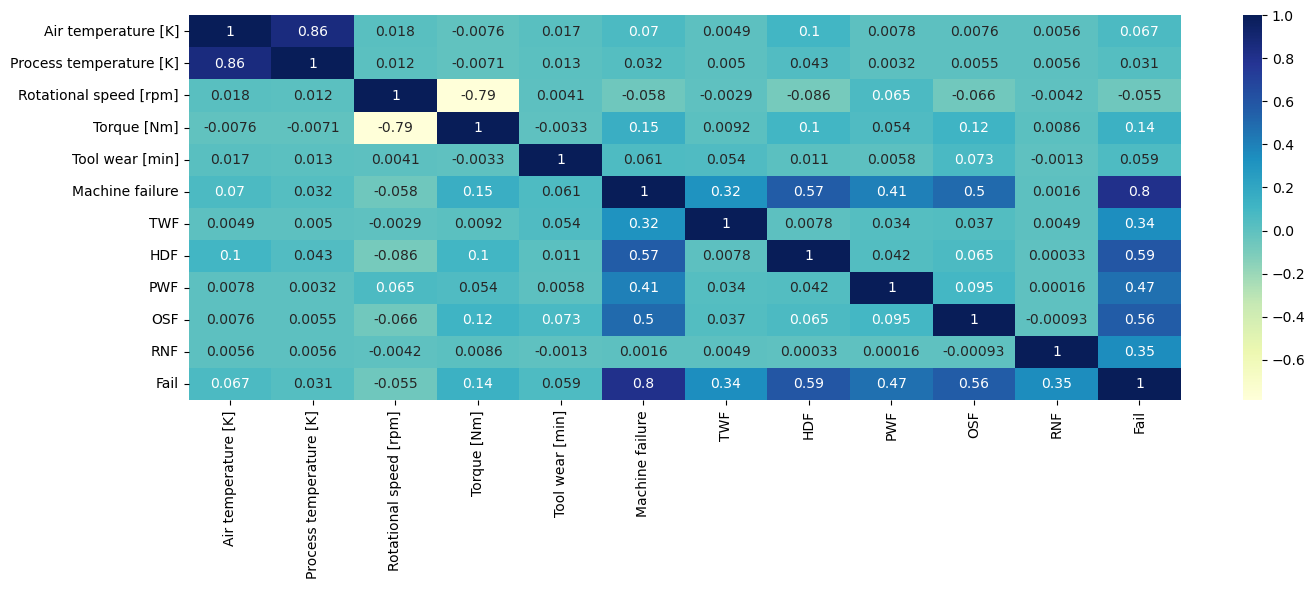

In [5]:
plt.figure(figsize = (16,5))
sns.heatmap(train_data.corr(),cmap="YlGnBu", annot=True)

If the operational/process temperature is much higher than the surrounding/air temperature there might be something there

In [6]:
train_data['Tdiff'] = train_data['Air temperature [K]'] - train_data['Process temperature [K]'] 
test_data['Tdiff'] = test_data['Air temperature [K]'] - test_data['Process temperature [K]'] 

/tmp/ipykernel_20/853492721.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(),cmap="YlGnBu", annot=True)


<Axes: >

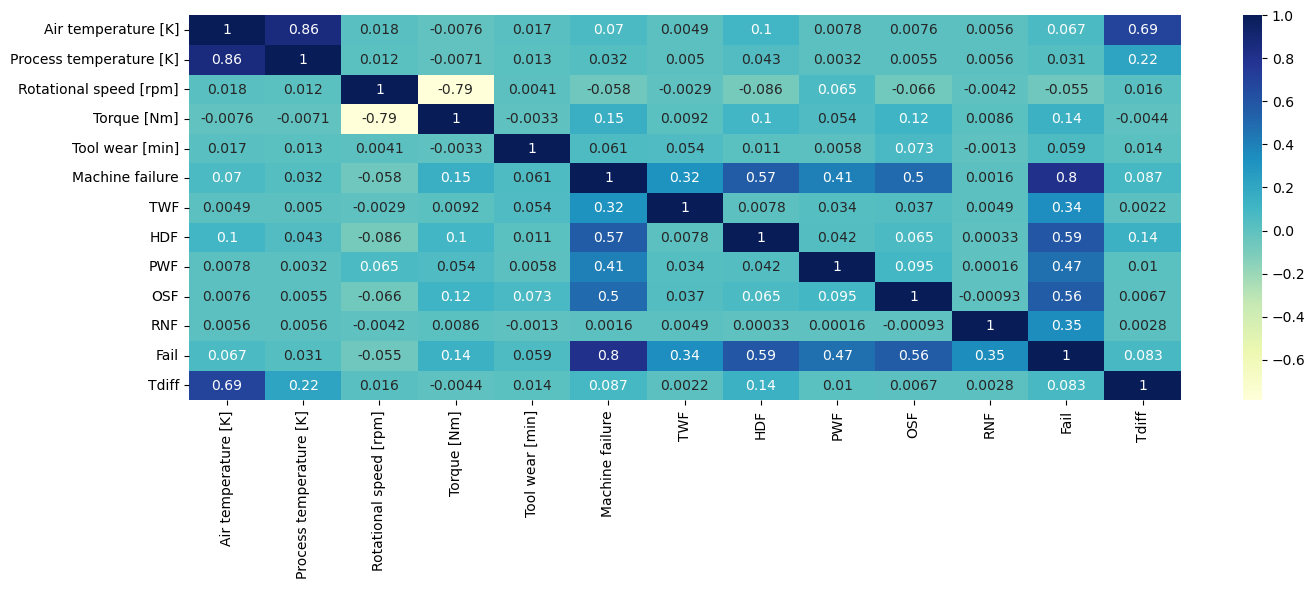

In [7]:
plt.figure(figsize = (16,5))
sns.heatmap(train_data.corr(),cmap="YlGnBu", annot=True)

- UID: unique identifier ranging from 1 to 10000
- productID: consisting of a letter L, M, or H for low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
- 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

- HDF : Heat Dissipation Failure
- PWF : Power failure
- OSF : Overstrain Failure
- TWF : Tool Wear Failure

## Type

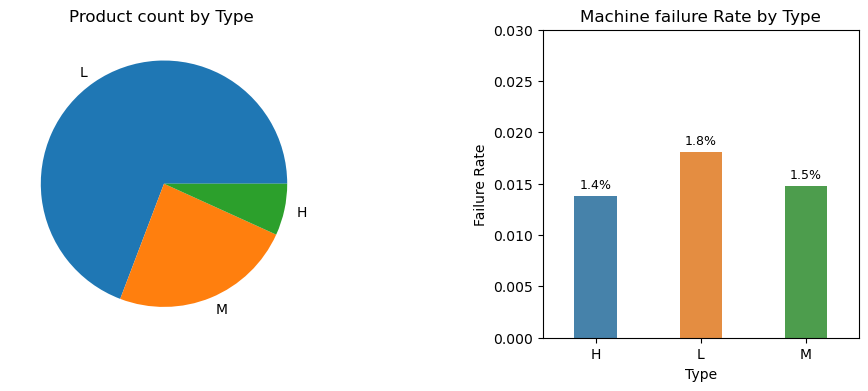

In [8]:
fig= plt.figure(figsize=(11,4))
type_count = train_data['Type'].value_counts()
ax1= plt.subplot(1,2,1)
ax1.pie(type_count.values, labels = type_count.index)
ax1.set_title("Product count by Type ")


ax2= plt.subplot(1,2,2)
type_failure_rate = train_data.groupby('Type')['Machine failure'].mean().reset_index()
sns.barplot(x='Type', y='Machine failure', data=type_failure_rate,  alpha= 0.9, width= 0.4, ax= ax2)
ax2.set_title('Machine failure Rate by Type')
ax2.set_ylabel('Failure Rate')
ax2.set_ylim([0, 0.03])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.7)
plt.show()

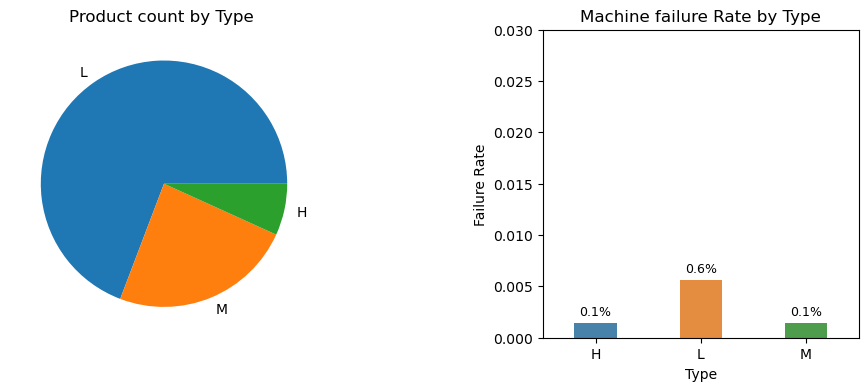

In [9]:
fig= plt.figure(figsize=(11,4))
type_count = train_data['Type'].value_counts()
ax1= plt.subplot(1,2,1)
ax1.pie(type_count.values, labels = type_count.index)
ax1.set_title("Product count by Type ")


ax2= plt.subplot(1,2,2)
type_failure_rate = train_data.groupby('Type')['OSF'].mean().reset_index()
sns.barplot(x='Type', y='OSF', data=type_failure_rate,  alpha= 0.9, width= 0.4, ax= ax2)
ax2.set_title('Machine failure Rate by Type')
ax2.set_ylabel('Failure Rate')
ax2.set_ylim([0, 0.03])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.7)
plt.show()

#### CONF MATRIX

In [10]:
def train_classifier(clf,x_train,y_train,x_test,y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    score = roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])
    print(confusion_matrix(y_pred, y_test))
    print(score)
    return clf

In [11]:
le = LabelEncoder()
le.fit(train_data['Type'])
train_data['Type'] = le.transform(train_data['Type'])
test_data['Type'] = le.transform(test_data['Type'])

In [12]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler

train_data['Air temperature [K]'] /= 273.15
test_data['Air temperature [K]'] /= 273.15
train_data['Process temperature [K]'] /= 273.15
test_data['Process temperature [K]'] /= 273.15

scaler = MaxAbsScaler() 

scaler.fit(train_data[['Rotational speed [rpm]']])
train_data[['Rotational speed [rpm]']] = scaler.transform(train_data[['Rotational speed [rpm]']])
test_data[['Rotational speed [rpm]']] = scaler.transform(test_data[['Rotational speed [rpm]']])

scaler.fit(train_data[['Torque [Nm]']])
train_data[['Torque [Nm]']] = scaler.transform(train_data[['Torque [Nm]']])
test_data[['Torque [Nm]']] = scaler.transform(test_data[['Torque [Nm]']])

scaler.fit(train_data[['Tool wear [min]']])
train_data[['Tool wear [min]']] = scaler.transform(train_data[['Tool wear [min]']])
test_data[['Tool wear [min]']] = scaler.transform(test_data[['Tool wear [min]']])

In [13]:
train_data

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Fail,Tdiff
0,L50096,1,1.100494,1.133443,0.553015,0.471279,0.553360,0,0,0,0,0,0,0,-9.0
1,M20343,2,1.107816,1.142596,0.609494,0.379896,0.790514,0,0,0,0,0,0,0,-9.5
2,L49454,1,1.095735,1.129416,0.625433,0.345953,0.098814,0,0,0,0,0,0,0,-9.2
3,L53355,1,1.101959,1.138202,0.528067,0.578329,0.778656,0,0,0,0,0,0,0,-9.9
4,M24050,2,1.090976,1.131247,0.568607,0.462141,0.134387,0,0,0,0,0,0,0,-11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,2,1.093904,1.129050,0.555787,0.385117,0.055336,0,0,0,0,0,0,0,-9.6
9997,H39410,0,1.094271,1.129050,0.565489,0.415144,0.067194,0,0,0,0,0,0,0,-9.5
9998,M24857,2,1.094637,1.129782,0.569993,0.436031,0.086957,0,0,0,0,0,0,0,-9.6
9999,H39412,0,1.094637,1.130148,0.487872,0.633159,0.098814,0,0,0,0,0,0,0,-9.7


In [14]:
train_data.columns

Index(['Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Fail', 'Tdiff'],
      dtype='object')

In [15]:
X = train_data[['Type', 'Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Fail']]
Y = train_data['Machine failure']

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2)

In [17]:
X

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Fail
0,1,1.100494,1.133443,0.553015,0.471279,0.553360,0
1,2,1.107816,1.142596,0.609494,0.379896,0.790514,0
2,1,1.095735,1.129416,0.625433,0.345953,0.098814,0
3,1,1.101959,1.138202,0.528067,0.578329,0.778656,0
4,2,1.090976,1.131247,0.568607,0.462141,0.134387,0
...,...,...,...,...,...,...,...
9996,2,1.093904,1.129050,0.555787,0.385117,0.055336,0
9997,0,1.094271,1.129050,0.565489,0.415144,0.067194,0
9998,2,1.094637,1.129782,0.569993,0.436031,0.086957,0
9999,0,1.094637,1.130148,0.487872,0.633159,0.098814,0


In [18]:
from sklearn.ensemble import AdaBoostClassifier


clf = AdaBoostClassifier(n_estimators=50, random_state=42)
clf.fit(X_train, y_train).score(X_val, y_val)

0.9946732227002664

In [19]:
test_preds = clf.predict(test_data[['Type', 'Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Fail']])

In [20]:
sub_df = pd.read_csv("/kaggle/input/playground-series-s3e17/sample_submission.csv")
def submit_file(model, X_test, filename = 'submission.csv'):
    preds = model.predict_proba(X_test)
    predicted_prob = [pred[1] for pred in preds]
    sub_df['Machine failure'] = predicted_prob
    sub_df.to_csv(filename, index = False)

In [21]:
submit_file(clf, test_data[['Type', 'Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Fail']])

# V5 Validation 0.995253704841904